In [2]:
import os
import cv2
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

In [3]:

directory = '' #Path to ReCaptcha Dataset
extension = 'png'

image_paths = []
labels = []

# Iterate through subdirectories
for subdir in os.listdir(directory):
    subdir_path = os.path.join(directory, subdir)
    
    # Ensure it's a directory
    if not os.path.isdir(subdir_path):
        continue
    
    # Iterate through image files in subdirectory
    for file_path in glob.glob(os.path.join(subdir_path, f'*.{extension}')):
        image_paths.append(file_path)
        labels.append(subdir)

# Ensure uniform image size and channels
desired_size = (224, 224)  # Change as per your requirement
images = [cv2.resize(cv2.imread(path), desired_size) for path in image_paths]

# Ensure all images are loaded
if any(img is None for img in images):
    print("Some images could not be loaded, check file paths and formats.")


In [6]:
# Ensure data is NumPy array
images_np = np.array(images)
labels_np = np.array(labels)    

# Check shapes of arrays
print(f"Shape of images array: {images_np.shape}")
print(f"Shape of labels array: {labels_np.shape}")

# Preprocess labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels_np)
labels_one_hot = tf.keras.utils.to_categorical(integer_encoded)

# Split data into train and test sets
train_images, test_images, train_labels, test_labels = train_test_split(images_np, labels_one_hot, test_size=0.2, random_state=42)

# Normalize image data
train_images, test_images = train_images / 255.0, test_images / 255.0


Shape of images array: (1943, 224, 224, 3)
Shape of labels array: (1943,)


In [9]:
train_labels.shape

(1554, 3)

In [7]:

# Define a simple CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(set(labels)))  # Set the output layer size equal to the number of unique labels
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [8]:
print(set(labels))

{'Stair', 'Bicycle', 'Hydrant'}


In [9]:
# Train the model
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/10
49/49 [==============================] - 110s 2s/step - loss: 1.3136 - accuracy: 0.5824 - val_loss: 0.6834 - val_accuracy: 0.7352
Epoch 2/10
49/49 [==============================] - 105s 2s/step - loss: 0.5924 - accuracy: 0.7600 - val_loss: 0.5303 - val_accuracy: 0.7995
Epoch 3/10
49/49 [==============================] - 104s 2s/step - loss: 0.4791 - accuracy: 0.8108 - val_loss: 0.6121 - val_accuracy: 0.7558
Epoch 4/10
49/49 [==============================] - 103s 2s/step - loss: 0.4396 - accuracy: 0.8366 - val_loss: 0.4709 - val_accuracy: 0.8021
Epoch 5/10
49/49 [==============================] - 103s 2s/step - loss: 0.3150 - accuracy: 0.8855 - val_loss: 0.3997 - val_accuracy: 0.8406
Epoch 6/10
49/49 [==============================] - 102s 2s/step - loss: 0.2536 - accuracy: 0.9041 - val_loss: 0.5430 - val_accuracy: 0.7841
Epoch 7/10
49/49 [==============================] - 102s 2s/step - loss: 0.2559 - accuracy: 0.8983 - val_loss: 0.4679 - val_accuracy: 0.8201
Epoch 8/10
49

In [18]:
print('\nTest accuracy:', test_acc*100, "%")


Test accuracy: 82.00514316558838 %


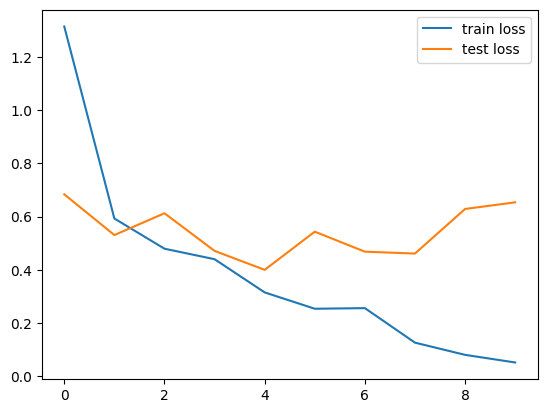

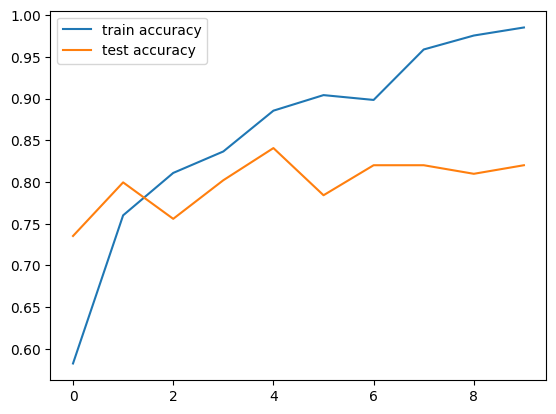

In [10]:
#plot loss graphs
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()

#plot accuracy graphs
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 205ms/step


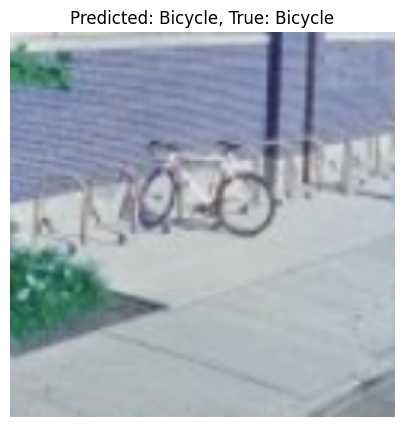

In [11]:
import matplotlib.pyplot as plt

# 1. Choose a random image from the test dataset
random_idx = np.random.choice(len(test_images))
random_image = test_images[random_idx]
random_label = test_labels[random_idx]

# 2. Preprocess the chosen image
# Since the model expects batches of images, expand dimensions to simulate a batch of size 1
random_image_batch = np.expand_dims(random_image, axis=0)

# 3. Use the model to predict the label for the chosen image
predictions = model.predict(random_image_batch)
predicted_label = np.argmax(predictions)

# Decode one-hot encoded labels to their original string form
predicted_label_str = label_encoder.inverse_transform([predicted_label])[0]
true_label_str = label_encoder.inverse_transform([np.argmax(random_label)])[0]

# 4. Display the image, the predicted label, and the true label
plt.figure(figsize=(5,5))
plt.imshow(random_image)
plt.title(f"Predicted: {predicted_label_str}, True: {true_label_str}")
plt.axis("off")
plt.show()


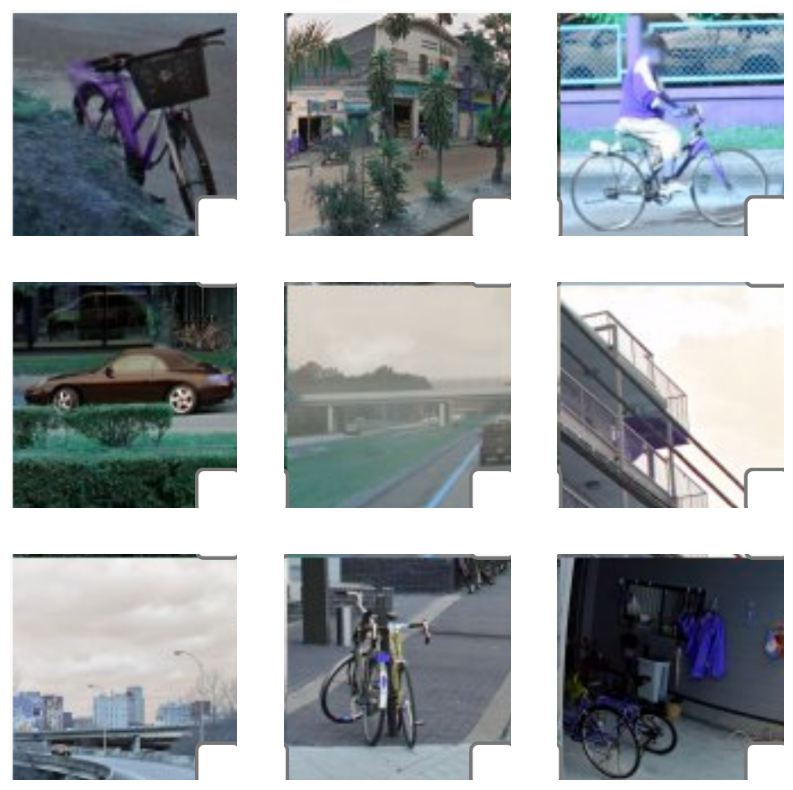

In [15]:
#Cropping the image into 9 equal parts

# Load the image
image = cv2.imread(r'C:\Users\bhave\OneDrive\Pictures\Screenshots\Screenshot (94).png')  # Replace with your image file path

# Get the dimensions of the original image
height, width, _ = image.shape

# Define the number of rows and columns for cropping
rows = 3
cols = 3

# Calculate the height and width of each cropped region
crop_height = height // rows
crop_width = width // cols

# Initialize variables to keep track of the cropping region
y1, y2 = 0, crop_height
x1, x2 = 0, crop_width

# Initialize a list to store the cropped images
cropped_images = []

# Loop through rows and columns to crop the image
for i in range(rows):
    x1 = 0  # Reset the starting x-coordinate for each row
    x2 = crop_width
    for j in range(cols):
        cropped = image[y1:y2, x1:x2]
        cropped_images.append(cropped)
        
        # Update x-coordinates for the next column
        x1 = x2
        x2 += crop_width
    # Update y-coordinates for the next row
    y1 = y2
    y2 += crop_height

# Display or save the cropped images
for i, cropped in enumerate(cropped_images):
    cv2.imwrite(f'cropped_image_{i}.jpg', cropped)  # To save the cropped images

plt.figure(figsize=(10,10))

for i in range(0,9):
    plt.subplot(3, 3, i+1)
    plt.imshow(cropped_images[i])
    plt.axis("off")

In [13]:
(cropped_images[0]).shape

(265, 265, 3)

1/1 [==============================] - 0s 132ms/step


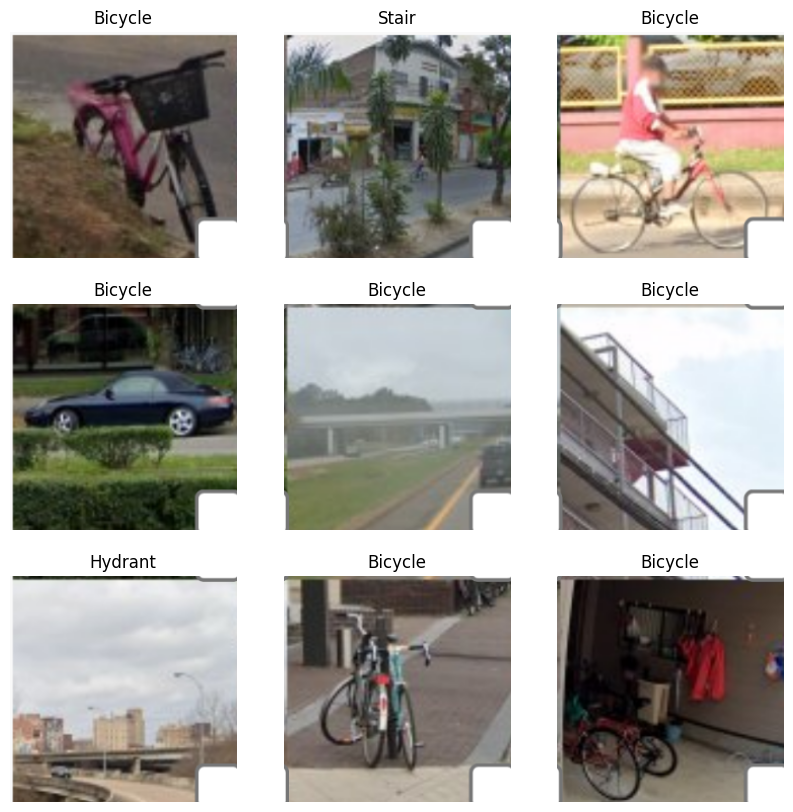

In [16]:
#Predicting the output for the cropped images

# Resize all the cropped images to (224, 224)
cropped_images_resized = [cv2.resize(img, (224, 224)) for img in cropped_images]

# Convert the list of resized images into a numpy array
cropped_images_array = np.array(cropped_images_resized)

# Make predictions for all cropped images
predictions = model.predict(cropped_images_array)

# Get the predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Decode one-hot encoded labels to their original string form
predicted_labels_str = label_encoder.inverse_transform(predicted_labels)

# Display the predictions
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cv2.cvtColor(cropped_images_resized[i], cv2.COLOR_BGR2RGB))
    plt.title(predicted_labels_str[i])
    plt.axis("off")

plt.show()
